# Coursework 2: Generative Models

## Instructions

### Submission
Please submit one zip file on cate - *CW2.zip* containing the following:
1. A version of this notebook containing your answers. Write your answers in the cells below each question. **Please deliver the notebook including the outputs of the cells**
2. Your trained VAE model as *VAE_model.pth*
3. Your trained Generator and Discriminator: *DCGAN_model_D.pth and DCGAN_model_G.pth*


### Training
Training the GAN will take quite a long time (multiple hours), please refer to the 4 GPU options detailed in the logistics lecture. Some additional useful pointers:
* PaperSpace [guide if you need more compute](https://hackmd.io/@afspies/S1stL8Qnt)
* Lab GPUs via SSH.  The VSCode Remote Develop extension is recommended for this. For general Imperial remote working instructions see [this post](https://www.doc.ic.ac.uk/~nuric/teaching/remote-working-for-imperial-computing-students.html). You'll also want to [setup your environment as outlined here](https://hackmd.io/@afspies/Bkd7Zq60K).
* Use Colab and add checkpointing to the model training code; this is to handle the case where colab stops a free-GPU kernel after a certain number of hours (~4).
* Use Colab Pro - If you do not wish to use PaperSpace then you can pay for Colab Pro. We cannot pay for this on your behalf (this is Google's fault).


### Testing
TAs will run a testing cell (at the end of this notebook), so you are required to copy your data ```transform``` and ```denorm``` functions to a cell near the bottom of the document (it is demarkated). You are advised to check that your implementations pass these tests (in particular, the jit saving and loading may not work for certain niche functions)

### General
You can feel free to add architectural alterations / custom functions outside of pre-defined code blocks, but if you manipulate the model's inputs in some way, please include the same code in the TA test cell, so our tests will run easily.

<font color="orange">**The deadline for submission is Monday, 26 Feb by 6 pm** </font>

## Setting up working environment
You will need to install pytorch and import some utilities by running the following cell:

In [25]:
!pip install -q torch torchvision altair seaborn
!git clone -q https://github.com/afspies/icl_dl_cw2_utils
from icl_dl_cw2_utils.utils.plotting import plot_tsne
from pathlib import Path
import tqdm

fatal: destination path 'icl_dl_cw2_utils' already exists and is not an empty directory.


Here we have some default pathing options which vary depending on the environment you are using. You can of course change these as you please.

In [26]:
# Initialization Cell
# Initialization Cell
WORKING_ENV = 'COLAB' # Can be LABS, COLAB, PAPERSPACE, SAGEMAKER
USERNAME = '' # If working on Lab Machines - Your college username
assert WORKING_ENV in ['LABS', 'COLAB', 'PAPERSPACE', 'SAGEMAKER']

if WORKING_ENV == 'COLAB':
    from google.colab import drive
    %load_ext google.colab.data_table
    dl_cw2_repo_path = 'dl_cw2/' # path in your gdrive to the repo
    content_path = f'/content/drive/MyDrive/CW2_NEW' # path to gitrepo in gdrive after mounting
    data_path = './data/' # save the data locally
    drive.mount('/content/drive/') # Outputs will be saved in your google drive

elif WORKING_ENV == 'LABS':
    content_path = f'/vol/bitbucket/{USERNAME}/dl/dl_cw2/' # You may want to change this
    data_path = f'/vol/bitbucket/{USERNAME}/dl/'
    # Your python env and training data should be on bitbucket
    if 'vol/bitbucket' not in content_path or 'vol/bitbucket' not in data_path:
        import warnings
        warnings.warn(
           'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
           )
elif WORKING_ENV == 'PAPERSPACE': # Using Paperspace
    # Paperspace does not properly render animated progress bars
    # Strongly recommend using the JupyterLab UI instead of theirs
    !pip install ipywidgets
    content_path = '/notebooks/'
    data_path = './data/'

elif WORKING_ENV == 'SAGEMAKER':
    content_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/dl/'
    data_path = f'{content_path}data/'

else:
  raise NotImplementedError()

content_path = Path(content_path)

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Introduction

For this coursework, you are asked to implement two commonly used generative models:
1. A **Variational Autoencoder (VAE)**
2. A **Deep Convolutional Generative Adversarial Network (DCGAN)**

For the first part you will the MNIST dataset https://en.wikipedia.org/wiki/MNIST_database and for the second the CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html).

Each part is worth 50 points.

The emphasis of both parts lies in understanding how the models behave and learn, however, some points will be available for getting good results with your GAN (though you should not spend too long on this).

# Part 1 - Variational Autoencoder

## Part 1.1 (25 points)
**Your Task:**

a. Implement the VAE architecture with accompanying hyperparameters. More marks are awarded for using a Convolutional Encoder and Decoder.

b. Design an appropriate loss function and train the model.


In [27]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_VAE/'):
    os.makedirs(content_path/'CW_VAE/')

if not os.path.exists(data_path):
    os.makedirs(data_path)

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

Using cuda


---
## Part 1.1a: Implement VAE (25 Points)
### Hyper-parameter selection


In [28]:
# Necessary Hyperparameters
num_epochs = 30
learning_rate = 1e-4
batch_size = 64
latent_dim = 50
# Choose a value for the size of the latent space

# Additional Hyperparameters


# (Optionally) Modify transformations on input
transform = transforms.Compose([
    transforms.ToTensor(),
])

# (Optionally) Modify the network's output for visualizing your images
def denorm(x):
    return x

### Data loading


In [29]:
train_dat = datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
test_dat = datasets.MNIST(data_path, train=False, transform=transform)

loader_train = DataLoader(train_dat, batch_size, shuffle=True)
loader_test = DataLoader(test_dat, batch_size, shuffle=False)

# Don't change
sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[:32, :, :, :]
save_image(fixed_input, content_path/'CW_VAE/image_original.png')

### Model Definition

<figure>
  <img src="https://blog.bayeslabs.co/assets/img/vae-gaussian.png" style="width:60%">
  <figcaption>
    Fig.1 - VAE Diagram (with a Guassian prior), taken from <a href="https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae.html">1</a>.
  </figcaption>
</figure>


You will need to define:
* The hyperparameters
* The constructor
* encode
* reparametrize
* decode
* forward



Hints:
- It is common practice to encode the log of the variance, rather than the variance
- You might try using BatchNorm

In [30]:
# *CODE FOR PART 1.1a IN THIS CELL*

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################

        ###### Encoder Layers ######
        # Create Convolution Layer
        self.encoder_l1 = nn.Sequential(nn.Conv2d(1, 16, 3),nn.BatchNorm2d(16),nn.ReLU())
        self.encoder_l2 = nn.Sequential(nn.Conv2d(16, 32, 3),nn.BatchNorm2d(32),nn.ReLU())
        # We add linear layers to create fully connected layers.
        # This facilitate spatial to abstract feature learning later
        self.encoder_l3 = nn.Sequential(nn.Linear(32*24*24, 512),nn.ReLU())
        self.encoder_l4 = nn.Sequential(nn.Linear(512, 256),nn.ReLU()) # Output 256px
        # Use the Output 256px Fully Connected layer
        # find the mean and logvar of the latent space of size latent_dim
        self.fullyConnected_mean = nn.Linear(256, latent_dim)
        self.fullyConnected_logvar = nn.Linear(256, latent_dim)
        ###### End Encoder Layers ######

        ###### Decoder Layers ######
        ## Basically reconstruct the image from latent representation
        # convert from latent dimension to 256 units
        self.decoder_l1 = nn.Sequential(nn.Linear(latent_dim, 256), nn.ReLU())
        # Perform the reverse of all the encoders to
        self.decoder_l2 = nn.Sequential(nn.Linear(256, 512), nn.ReLU())
        self.decoder_l3 = nn.Sequential(nn.Linear(512, 32*24*24), nn.ReLU())
        self.decoder_l4 = nn.Sequential(nn.ConvTranspose2d(32, 16, 3), nn.ReLU())
        # Note: We used sigmoid here because we want to ensure that the pixel value is within the range 0 and 1.
        # This is done because we are working with MINST dataset which uses grayscale.
        self.decoder_l5 = nn.Sequential(nn.ConvTranspose2d(16, 1, 3), nn.Sigmoid())
        ###### End Decoder Layers ######

        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def encode(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Create convolution
        encoder = self.encoder_l1(x)
        encoder = self.encoder_l2(encoder)
        # Reshape the 4D tensor to flatten channel width and height
        batch_size, channel, width,height = encoder.shape
        encoder = encoder.view(batch_size,channel*width*height)
        # Use the reshaped tensor to make fully connected (linear) layer
        encoder = self.encoder_l3(encoder)
        encoder = self.encoder_l4(encoder)

        mu = self.fullyConnected_mean(encoder)
        logvar = self.fullyConnected_logvar(encoder)

        return mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def reparametrize(self, mu, logvar):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def decode(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        decoder = self.decoder_l1(z)
        decoder = self.decoder_l2(decoder)
        decoder = self.decoder_l3(decoder)
        # Reshape fully connected layer to have size 32*24*24 same as in decoder and encoder l3
        # automatically determine batch size
        decoder = decoder.view(-1, 32, 24,24)
        decoder = self.decoder_l4(decoder)
        decoder = self.decoder_l5(decoder)

        return decoder
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        mu , logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        reconstructed_input = self.decode(z)

        return reconstructed_input, mu, logvar
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

## As we are using linear fully connected method, we should initialize the weights of linear layers
# Use kaiming_uniform.
def init_he(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

model = VAE(latent_dim).to(device)
model.apply(init_he)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))
print(model)
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Total number of parameters is: 19204645
VAE(
  (encoder_l1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (encoder_l3): Sequential(
    (0): Linear(in_features=18432, out_features=512, bias=True)
    (1): ReLU()
  )
  (encoder_l4): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
  )
  (fullyConnected_mean): Linear(in_features=256, out_features=50, bias=True)
  (fullyConnected_logvar): Linear(in_features=256, out_features=50, bias=True)
  (decoder_l1): Sequential(
    (0): Linear(in_features=50, out_features=256, bias=True)
    (1): ReLU()
  )
  (decoder_l2): Sequential(
    (0): Linear(in_features=256, out_features=512

---

## Part 1.1b: Training the Model (5 Points)

### Defining a Loss
Recall the Beta VAE loss, with an encoder $q$ and decoder $p$:
$$ \mathcal{L}=\mathbb{E}_{q_\phi(z \mid X)}[\log p_\theta(X \mid z)]-\beta D_{K L}[q_\phi(z \mid X) \| p_\theta(z)]$$

In order to implement this loss you will need to think carefully about your model's outputs and the choice of prior.

There are multiple accepted solutions. Explain your design choices based on the assumptions you make regarding the distribution of your data.

* Hint: this refers to the log likelihood as mentioned in the tutorial. Make sure these assumptions reflect on the values of your input data, i.e. depending on your choice you might need to do a simple preprocessing step.

* You are encouraged to experiment with the weighting coefficient $\beta$ and observe how it affects your training

In [31]:
# *CODE FOR PART 1.1b IN THIS CELL*
# beta can be hyperparameter tuned later
def loss_function_VAE(recon_x, x, mu, logvar, beta = 2):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Binary Cross Entrophy
        BCE_loss = F.binary_cross_entropy(recon_x, x, size_average=False, reduction='sum')
        KLD_loss = -0.5 * torch.sum(1 + logvar - mu**(2) - logvar.exp())
        total_loss = BCE_loss + beta * KLD_loss

        return BCE_loss, KLD_loss, total_loss
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

model.train()
# <- You may wish to add logging info here
## Store loss training information
train_total_losses = []
train_BCE_losses = []
train_KLD_losses = []

## Store final training information
valid_total_losses = []
valid_BCE_losses = []
valid_KLD_losses = []

for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:

        train_loss, train_BCE_loss, train_KLD_loss = 0.0, 0.0, 0.0
        for batch_idx, (data, _) in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # Need at least one batch/random data with right shape -
            # This is required to initialize to model properly below
            # when we save the computational graph for testing (jit.save)

            # Fetch the data
            data = data.to(device)
            optimizer.zero_grad()

            # Perform Forward
            recon_x, mu, logvar = model.forward(data)

            # Get the Loss
            BCE_loss, KLD_loss, total_loss = loss_function_VAE(recon_x, data, mu, logvar)


            # Store loss training parameters:
            train_loss += total_loss / data.shape[0]
            train_BCE_loss += BCE_loss / data.shape[0]
            train_KLD_loss += KLD_loss / data.shape[0]

            total_loss.backward()
            optimizer.step()

            # Perform without gradient descent to use on test set.
            valid_total_loss, valid_BCE_loss, valid_KLD_loss = 0.0, 0.0, 0.0
            model.eval()
        with torch.no_grad():
            for batch_idx, (data, _) in enumerate(loader_test):

                data = data.to(device)

                optimizer.zero_grad()

                recon_x, mu, logvar = model(data)

                BCE_loss, KLD_loss, total_loss = loss_function_VAE(recon_x, data, mu, logvar)

                valid_total_loss += total_loss/ data.shape[0]
                valid_BCE_loss += BCE_loss / data.shape[0]
                valid_KLD_loss += KLD_loss / data.shape[0]

        # Store all the loss information
        print('epoch [{}/{}], Training loss:{:.4f}, Validation loss:{:.4f}'.format(
            epoch + 1,
            num_epochs,
            train_loss / len(loader_train.dataset),
            valid_total_loss / len(loader_test.dataset))
        )

        train_total_losses.append(train_loss / len(loader_train.dataset))
        train_BCE_losses.append(train_BCE_loss / len(loader_train.dataset))
        train_KLD_losses.append(train_KLD_loss / len(loader_train.dataset))

        valid_total_losses.append(valid_total_loss / len(loader_test.dataset))
        valid_BCE_losses.append(valid_BCE_loss / len(loader_test.dataset))
        valid_KLD_losses.append(valid_KLD_loss / len(loader_test.dataset))



        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        # if batch_idx % 20 == 0:
        #     tepoch.set_description(f"Epoch {epoch}")
        #     tepoch.set_postfix(loss=loss.item()/len(data))

    # save the model
    print("Complete")
    if epoch == num_epochs - 1:
        print("finished training")
        with torch.no_grad():
            torch.jit.save(torch.jit.trace(model, (data), check_trace=False),
                content_path/'CW_VAE/VAE_model.pth')



  0%|          | 0/938 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 938/938 [00:18<00:00, 50.05batch/s]


epoch [1/30], Training loss:3.1417, Validation loss:2.5566
Complete


100%|██████████| 938/938 [00:15<00:00, 62.50batch/s]


epoch [2/30], Training loss:2.4451, Validation loss:2.3565
Complete


100%|██████████| 938/938 [00:14<00:00, 63.38batch/s]


epoch [3/30], Training loss:2.2939, Validation loss:2.2312
Complete


100%|██████████| 938/938 [00:14<00:00, 64.25batch/s]


epoch [4/30], Training loss:2.2001, Validation loss:2.1662
Complete


100%|██████████| 938/938 [00:14<00:00, 66.01batch/s]


epoch [5/30], Training loss:2.1391, Validation loss:2.1105
Complete


100%|██████████| 938/938 [00:14<00:00, 66.30batch/s]


epoch [6/30], Training loss:2.0920, Validation loss:2.0722
Complete


100%|██████████| 938/938 [00:13<00:00, 67.32batch/s]


epoch [7/30], Training loss:2.0560, Validation loss:2.0381
Complete


100%|██████████| 938/938 [00:13<00:00, 68.29batch/s]


epoch [8/30], Training loss:2.0265, Validation loss:2.0149
Complete


100%|██████████| 938/938 [00:13<00:00, 70.30batch/s]


epoch [9/30], Training loss:2.0036, Validation loss:1.9893
Complete


100%|██████████| 938/938 [00:12<00:00, 76.35batch/s]


epoch [10/30], Training loss:1.9821, Validation loss:1.9747
Complete


100%|██████████| 938/938 [00:11<00:00, 81.53batch/s]


epoch [11/30], Training loss:1.9637, Validation loss:1.9538
Complete


100%|██████████| 938/938 [00:11<00:00, 81.15batch/s]


epoch [12/30], Training loss:1.9501, Validation loss:1.9451
Complete


100%|██████████| 938/938 [00:11<00:00, 82.20batch/s]


epoch [13/30], Training loss:1.9357, Validation loss:1.9324
Complete


100%|██████████| 938/938 [00:11<00:00, 83.02batch/s]


epoch [14/30], Training loss:1.9250, Validation loss:1.9225
Complete


100%|██████████| 938/938 [00:11<00:00, 81.40batch/s]


epoch [15/30], Training loss:1.9150, Validation loss:1.9138
Complete


100%|██████████| 938/938 [00:11<00:00, 82.56batch/s]


epoch [16/30], Training loss:1.9032, Validation loss:1.9045
Complete


100%|██████████| 938/938 [00:11<00:00, 82.76batch/s]


epoch [17/30], Training loss:1.8949, Validation loss:1.8947
Complete


100%|██████████| 938/938 [00:11<00:00, 83.24batch/s]


epoch [18/30], Training loss:1.8877, Validation loss:1.8898
Complete


100%|██████████| 938/938 [00:11<00:00, 83.46batch/s]


epoch [19/30], Training loss:1.8787, Validation loss:1.8818
Complete


100%|██████████| 938/938 [00:11<00:00, 82.11batch/s]


epoch [20/30], Training loss:1.8731, Validation loss:1.8777
Complete


100%|██████████| 938/938 [00:11<00:00, 82.93batch/s]


epoch [21/30], Training loss:1.8673, Validation loss:1.8712
Complete


100%|██████████| 938/938 [00:11<00:00, 81.41batch/s]


epoch [22/30], Training loss:1.8616, Validation loss:1.8671
Complete


100%|██████████| 938/938 [00:11<00:00, 82.37batch/s]


epoch [23/30], Training loss:1.8548, Validation loss:1.8633
Complete


100%|██████████| 938/938 [00:11<00:00, 81.63batch/s]


epoch [24/30], Training loss:1.8501, Validation loss:1.8601
Complete


100%|██████████| 938/938 [00:11<00:00, 82.01batch/s]


epoch [25/30], Training loss:1.8450, Validation loss:1.8569
Complete


100%|██████████| 938/938 [00:11<00:00, 82.18batch/s]


epoch [26/30], Training loss:1.8402, Validation loss:1.8519
Complete


100%|██████████| 938/938 [00:11<00:00, 81.89batch/s]


epoch [27/30], Training loss:1.8353, Validation loss:1.8498
Complete


100%|██████████| 938/938 [00:11<00:00, 83.55batch/s]


epoch [28/30], Training loss:1.8318, Validation loss:1.8508
Complete


100%|██████████| 938/938 [00:11<00:00, 82.54batch/s]


epoch [29/30], Training loss:1.8276, Validation loss:1.8448
Complete


100%|██████████| 938/938 [00:11<00:00, 82.60batch/s]


epoch [30/30], Training loss:1.8247, Validation loss:1.8412
Complete
finished training


### Loss Explanation
Explain your choice of loss and how this relates to:

* The VAE Prior
* The output data domain
* Disentanglement in the latent space


In [32]:
# Any code for your explanation here (you may not need to use this cell)

**YOUR ANSWER**

Overview: Utilised the the Binary Cross-Entropy (BCE) loss and the Kullback-Leibler Divergence (KLD) loss.


**The VAE Prior**

The VAE is designed around the idea that latent variable uses gaussian distribution with where we have a  (mu) and a variance (logvar). KLD loss minimises the leaned distributioin of the latent variable to the Gaussian prior. 

`KLD_loss = -0.5 * torch.sum(1 + logvar - mu**(2) - logvar.exp())`

Minimising this helps us to regularise and incorporate previous knowledge from the previous VAE prior.



**The output data domain**

The VAE is used to generate image, the outputs are essentially pribabilities or intensity of the grayscale pixels used to generate a grayscale image. Binary Cross-Entropy (BCE) loss helps us to measure how well the reconstructed output match the original inputs.

`BCE_loss = F.binary_cross_entropy(recon_x, x, size_average=False, reduction='sum')`

Additionally, we use a sigmoid activation function in the final layer to ensure the output pixel is between 0 and 1 that is matching the domain of grayscale.


**Disentanglement in the latent space**

KLD penalizes deviations from the prior distribution, KLD loss indirectly encourages the latent variables to be independent of each other. Adding Beta to the total loss we put more weight on KLD relative to the BCE loss (reconstruction loss). If beta is larger, this encourage the model to prioritize learning disentangled and independent latent representations over perfect reconstruction. If B gets too large, overfocus on KLD results in little emphasis on reconstruction and can lead to very bad reconstruction results.


<h2>Part 1.2 (9 points)</h2>

a. Plot your loss curves

b. Show reconstructions and samples

c. Discuss your results from parts (a) and (b)

## Part 1.2a: Loss Curves (3 Points)
Plot your loss curves (6 in total, 3 for the training set and 3 for the test set): total loss, reconstruction log likelihood loss, KL loss (x-axis: epochs, y-axis: loss). If you experimented with different values of $\beta$, you may wish to display multiple plots (worth 1 point).

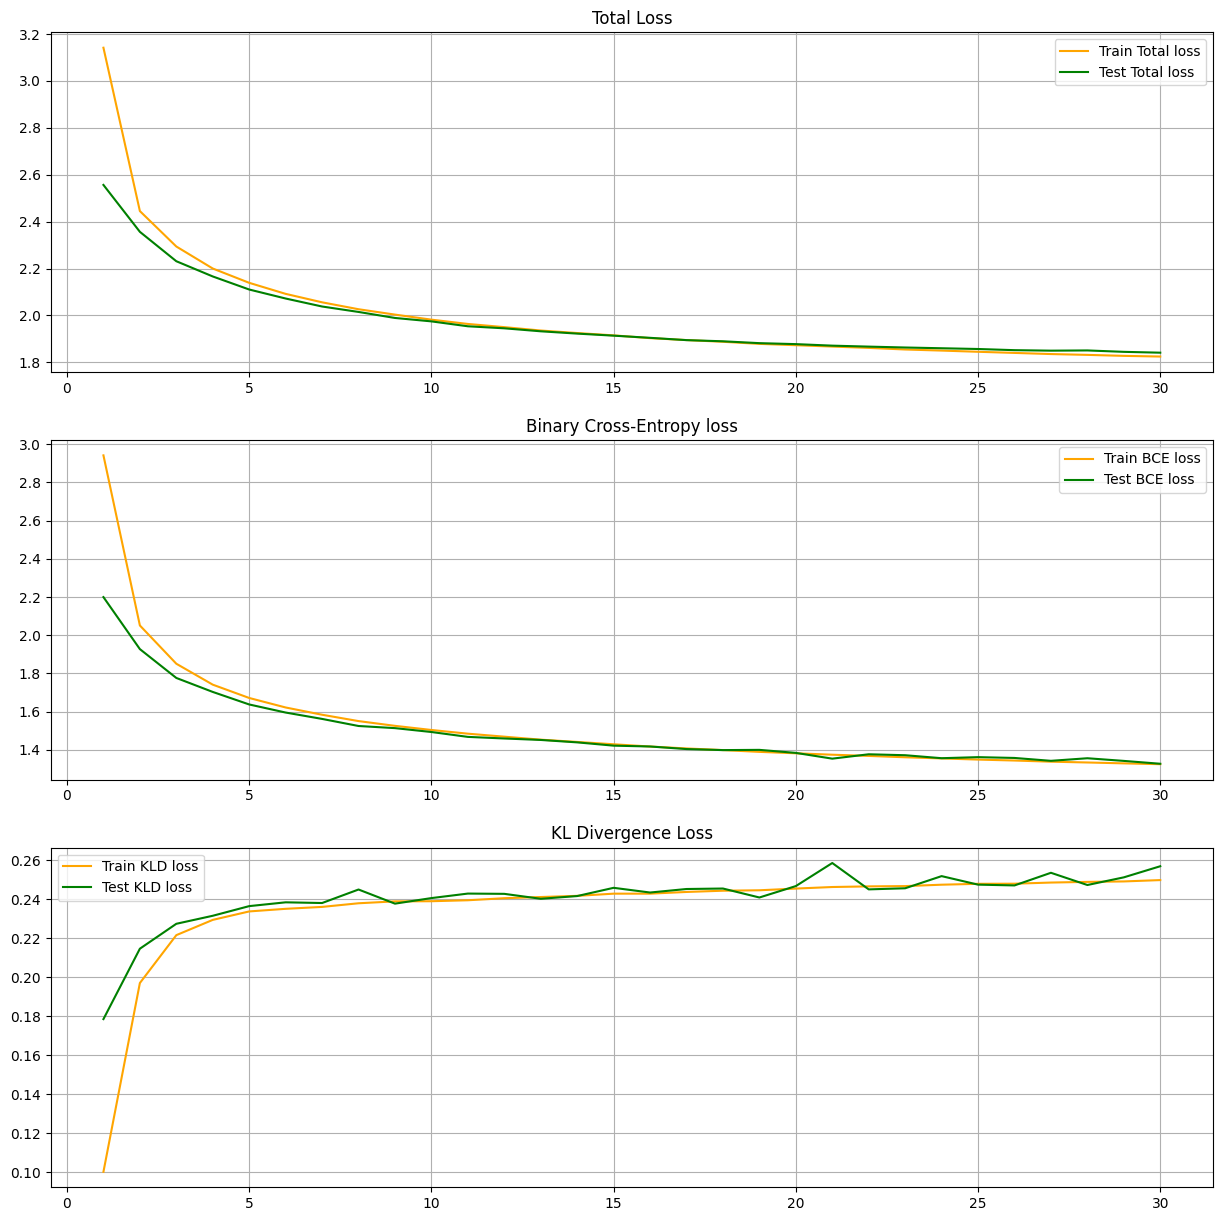

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(15,15))

train_total_losses_tensor = torch.tensor(train_total_losses)
valid_total_losses_tensor = torch.tensor(valid_total_losses)
train_BCE_losses_tensor = torch.tensor(train_BCE_losses)
valid_BCE_losses_tensor = torch.tensor(valid_BCE_losses)
train_KLD_losses_tensor = torch.tensor(train_KLD_losses)
valid_KLD_losses_tensor = torch.tensor(valid_KLD_losses)

axs[0].plot(list(range(1, 1 + len(train_total_losses))), train_total_losses_tensor, color='orange', label='Train Total loss')
axs[0].plot(list(range(1, 1 + len(valid_total_losses))), valid_total_losses_tensor, color='green', label='Test Total loss')
axs[0].legend()
axs[0].set_title('Total Loss')
axs[0].grid()

axs[1].plot(list(range(1, 1 + len(train_BCE_losses))), train_BCE_losses_tensor, color='orange', label='Train BCE loss')
axs[1].plot(list(range(1, 1 + len(valid_BCE_losses))), valid_BCE_losses_tensor, color='green', label='Test BCE loss')
axs[1].legend()
axs[1].set_title('Binary Cross-Entropy loss')
axs[1].grid()

axs[2].plot(list(range(1, 1 + len(train_KLD_losses))), train_KLD_losses_tensor, color='orange', label='Train KLD loss')
axs[2].plot(list(range(1, 1 + len(valid_KLD_losses))), valid_KLD_losses_tensor, color='green', label='Test KLD loss')
axs[2].legend()
axs[2].set_title('KL Divergence Loss')
axs[2].grid()

## Part 1.2b: Samples and Reconstructions (6 Points)
Visualize a subset of the images of the test set and their reconstructions **as well as** a few generated samples. Most of the code for this part is provided. You only need to call the forward pass of the model for the given inputs (might vary depending on your implementation).

For reference, here's [some samples from our VAE](https://imgur.com/NwNMuG3).


Input images
--------------------------------------------------
Reconstructed images
--------------------------------------------------
Generated Images
--------------------------------------------------


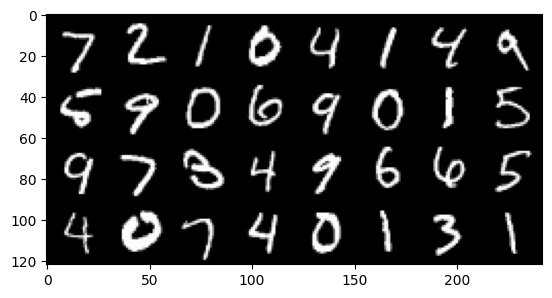

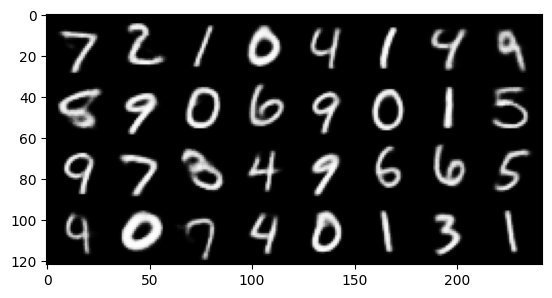

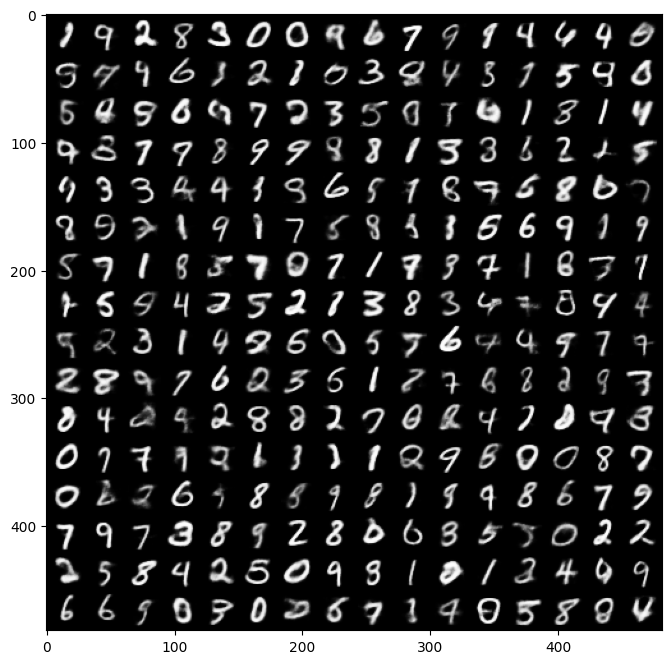

In [34]:
# *CODE FOR PART 1.2b IN THIS CELL*

# load the model
print('Input images')
print('-'*50)

sample_inputs, _ = next(iter(loader_test))
fixed_input = sample_inputs[0:32, :, :, :]
# visualize the original images of the last batch of the test set
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
show(img)

print('Reconstructed images')
print('-'*50)
with torch.no_grad():
    # visualize the reconstructed images of the last batch of test set

    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    recon_batch, _, _ = model(fixed_input.to(device))
    recon_batch = recon_batch.view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    recon_batch = recon_batch.cpu()
    recon_batch = make_grid(denorm(recon_batch), nrow=8, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure()
    show(recon_batch)

print('Generated Images')
print('-'*50)
model.eval()
n_samples = 256
z = torch.randn(n_samples,latent_dim).to(device)
with torch.no_grad():
    #######################################################################
    #                       ** START OF YOUR CODE **
    #######################################################################
    samples = model.decode(z).view(-1, 1, 28, 28)
    #######################################################################
    #                       ** END OF YOUR CODE **
    #######################################################################

    samples = samples.cpu()
    samples = make_grid(denorm(samples), nrow=16, padding=2, normalize=False,
                            value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize = (8,8))
    show(samples)



### Discussion
Provide a brief analysis of your loss curves and reconstructions:
* What do you observe in the behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)?
* Can you intuitively explain if this behaviour is desirable?
* What is posterior collapse and did you observe it during training (i.e. when the KL is too small during the early stages of training)?
    * If yes, how did you mitigate it? How did this phenomenon reflect on your output samples?
    * If no, why do you think that is?

**YOUR ANSWER**

In my code, Binary Cross Entropy loss (BCE_loss) serves as the log-likelihood loss, and the KL Divergence loss (KLD_loss) directly represents the KL loss.

**Behaviour of the log-likelihood loss and the KL loss (increasing/decreasing)**

The BCE loss is decreasing and the KLD loss increse while the total loss decreases. 


**Can you intuitively explain if this behaviour is desirable?**

The behavior we observe is actually desirable. The KLD has a log(x) curve which shows us that the model's latent distribution quickly approaches the prior distribution. 

The BCE loss has a -log(x) curve, implying that the VAE is getting better at reconstructing the input data.

As training progresses, the rate of change for both losses slows down, suggesting that the model is finding a balance between the data's BCE loss and the regularization imposed by the KL divergence.

**What is posterior collapse and did you observe it during training** 

Posterior collapse refers to a situation where the model's encoder starts to ignore the latent variables, essentially causing the variational aspect of the model to collapse. This typically happens when the KL divergence loss becomes too small or approaches zero, especially in the early stages of training.

From my observation, in training initially KLD loss is very very small especially when epoch is less than 5. Hence posterior collapse likely existed then. The image generated would be random pixels.

This is mitigated by 
1. letting epoch be above 10 to allow stabilisation. 
2. We also set a beta to be above 1 to set higher weights to KLD loss. This places more emphasis on the prior distibution. However we cannot set beta to be too high. Beta above 20 would start to see overemphasis on KLD loss and underweighing BCE loss. The image regenerated cannot differentiate between numbers well.



---
<h2> Part 1.3 (11 points) <h2/>

Qualitative analysis of the learned representations

In this question you are asked to qualitatively assess the representations that your model has learned. In particular:

a. Dimensionality Reduction of learned embeddings

b. Interpolating in the latent space

## Part 1.3a: T-SNE on Embeddings (7 Points)
Extract the latent representations of the test set and visualize them using [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)  [(see implementation)](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). You can use a T-SNE implementation from a library such as scikit-learn.

We've provided a function to visualize a subset of the data, but you are encouraged to also produce a matplotlib plot (please use different colours for each digit class).

In [35]:
# *CODE FOR PART 1.3a IN THIS CELL
#Definining Plot
from sklearn.manifold import TSNE

def plot_tsne(x, title):
    xmin, xmax = np.min(x, 0), np.max(x, 0)
    x = (x - xmin) / (xmax - xmin)
    plt.figure(figsize=(10,10))
    ax = plt.subplot()

    for i in range(x.shape[0]):
         plt.scatter(x[i, 0], x[i, 1], color=plt.cm.Paired(y[i]/10.), s=3)  # Adjust the size (s) here

    plt.title(title)


In [38]:

# Initialise lists to store data
test, x, y = None, None, None

#Initialise model
pretrained_model = torch.jit.load(content_path/'CW_VAE/VAE_model.pth')
model.load_state_dict(pretrained_model.state_dict())
model.eval()

## For test data
with torch.no_grad():
    # Load the representation from the TEST SET
    # Do it batch by batch
    for batch_idx, data in enumerate(loader_test):
        num, labels = data
        num = num.to(device)
        mu, logvar = model.encode(num)
        # Store data from test set
        test = np.concatenate((test, num.cpu().numpy())) if test is not None else num.cpu().numpy()
        # Store data from x set
        x = np.concatenate((x, mu.cpu().numpy())) if x is not None else mu.cpu().numpy()
        # Store data from y set
        y = np.concatenate((y, labels)) if y is not None else labels

#using sklearn
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(x)

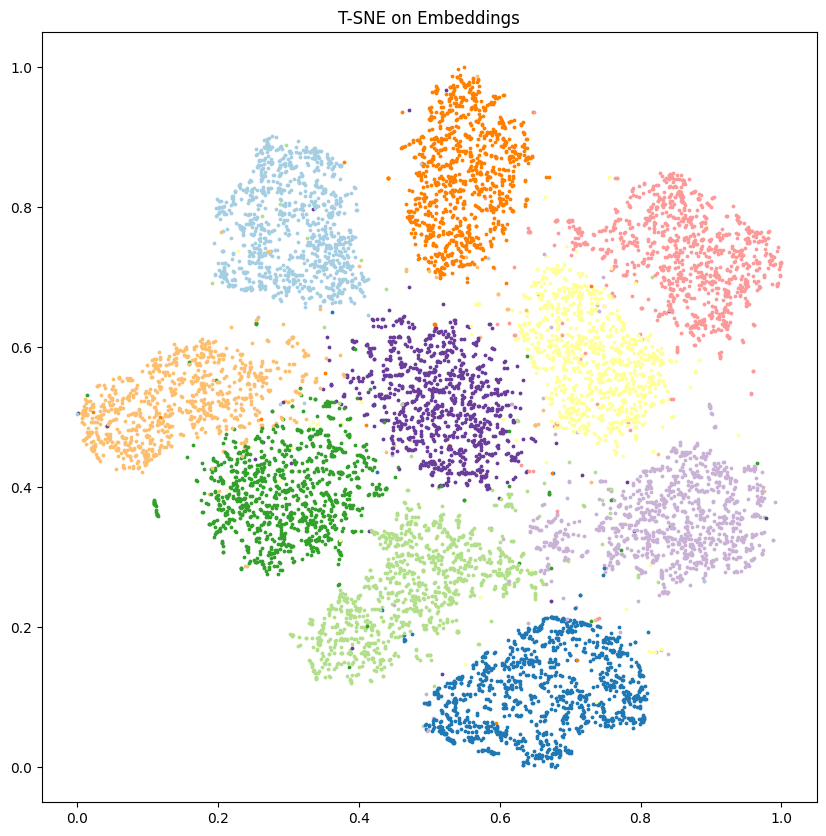

In [39]:
plot_tsne(tsne_results,"T-SNE on Embeddings" )

### Discussion
What do you observe? Discuss the structure of the visualized representations.
* What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?
    * Consider Outliers
    * Counsider Boundaries
    * Consider Clusters
* Is T-SNE reliable? What happens if you change the parameters (don't worry about being particularly thorough). [This link](https://distill.pub/2016/misread-tsne/) may be helpful.

Note - If you created multiple plots and want to include them in your discussion, the best option is to upload them to (e.g.) google drive and then embed them via a **public** share link. If you reference local files, please include these in your submission zip, and use relative pathing if you are embedding them (with the notebook in the base directory)

**YOUR ANSWER**

**What do you observe? What role do the KL loss term and $\beta$ have, if any, in what you observe (multiple matplotlib plots may be desirable here)?**

As beta increaase, there is larger emphasis on KL loss. It seems like when beta is large, and overemphasis on KLD, the there is less seperation among clusters. Visually comparoing a beta of 1 vs beta 10. There is more points that are in the cluster boundary, hence more boundary overlap. The distance between cluster smaller for beta 10 vs beta 1.
When the beta is 0.5 as an extreme example, the TSNE boundary is much more distinct.
When beta is 50, the TSNE boundary is non-existent and every single generated figure shows the same number

**Is T-SNE reliable?**

T-SNE not exactly reliable as it does not paint a full picture of the quality of generated image.
For example when we set beta to 0.5. TSNE shows a very clear boundary between clusters. However when we observe the generated images, the images are of quite bad quality. 
When beta is between 1-5 the boundary cluster TSNE shows us that boundary between clusters are acceptable, but the generated image quality is much better.


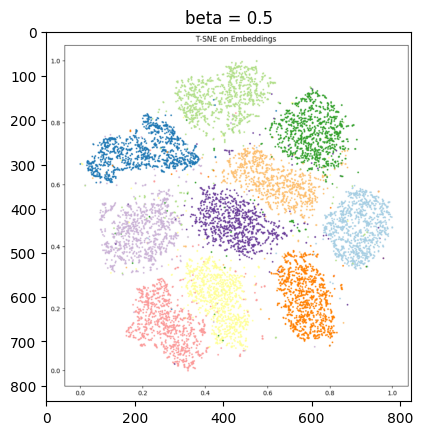

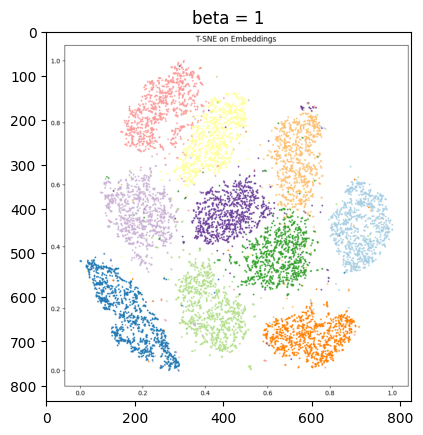

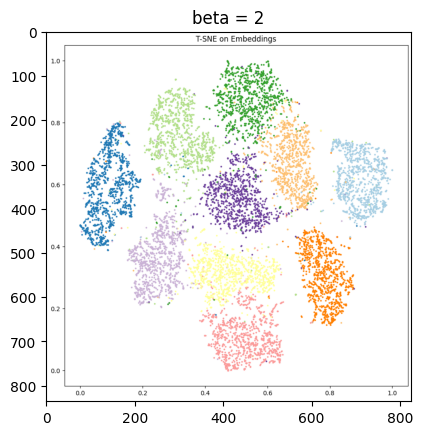

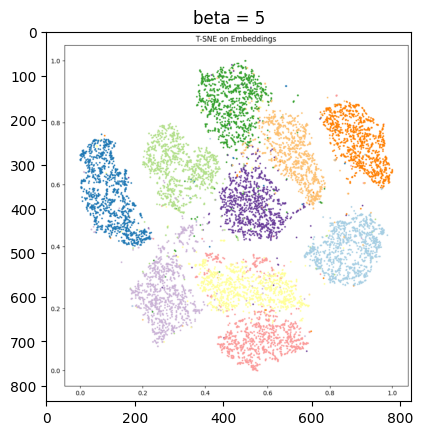

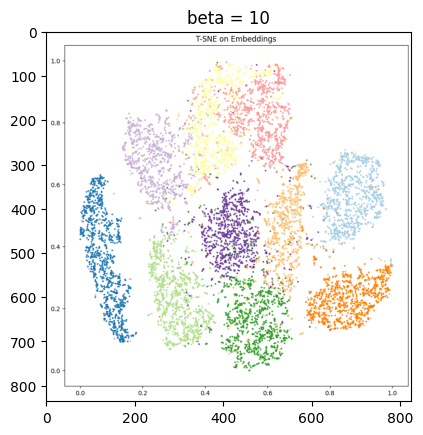

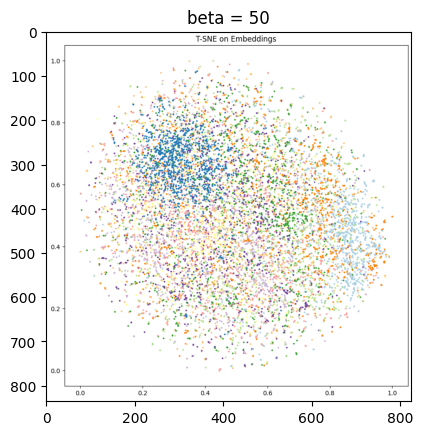

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('beta = 0.5.png')
plt.title('beta = 0.5')
plt.imshow(img)
plt.show()

img = mpimg.imread('beta = 1.png')
plt.title('beta = 1')
plt.imshow(img)
plt.show()

img = mpimg.imread('beta = 2.png')
plt.title('beta = 2')
plt.imshow(img)
plt.show()

img = mpimg.imread('beta = 5.png')
plt.title('beta = 5')
plt.imshow(img)
plt.show()

img = mpimg.imread('beta = 10.png')
plt.title('beta = 10')
plt.imshow(img)
plt.show()


img = mpimg.imread('beta = 50.png')
plt.title('beta = 50')
plt.imshow(img)
plt.show()

## Part 1.3b: Interpolating in $z$ (4 Points)
Perform a linear interpolation in the latent space of the autoencoder by choosing any two digits from the test set. What do you observe regarding the transition from on digit to the other?

_hint: Locate the positions in latent space of 2 data points (maybe a one and an eight). Then sample multiple latent space vectors along the line which joins the 2 points and pass them through the decoder._


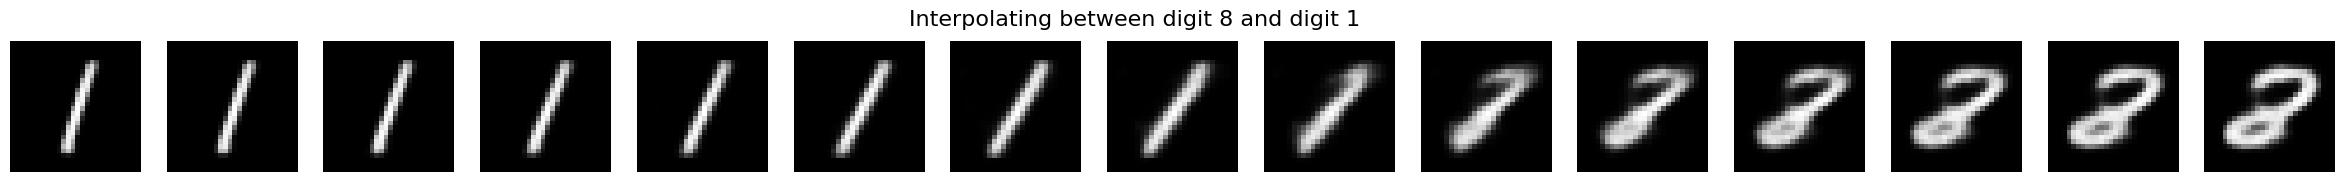

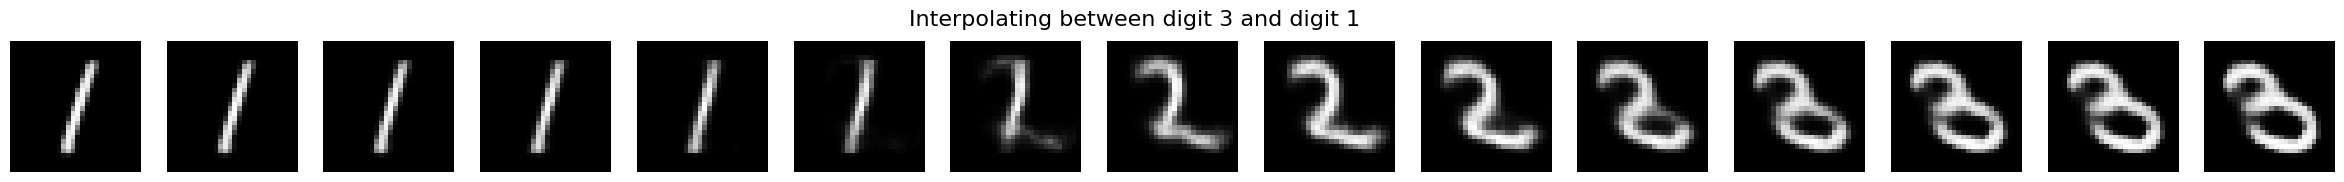

In [40]:
# CODE FOR PART 1.3b IN THIS CELL


def plot_interpolation(digit1, digit2):
  test_data, test_labels = next(iter(loader_test))

  # Find the indices of the selected digits in the test set
  idx_digit1 = (test_labels == digit1).nonzero(as_tuple=True)[0][0]
  idx_digit2 = (test_labels == digit2).nonzero(as_tuple=True)[0][0]

  # Encode the selected digits to get their latent representations
  x1 = torch.FloatTensor(test_data[idx_digit1]).reshape(1, 1, 28, 28).to(device)
  x2 = torch.FloatTensor(test_data[idx_digit2]).reshape(1, 1, 28, 28).to(device)
  mu1, var1 = model.encode(x1)
  mu2, var2 = model.encode(x2)

  # Sample points along the line connecting the latent representations of the two digits
  n_points = 15  # Number of points for interpolation
  interpolated = []
  for i in range(n_points):
      alpha = i / (n_points - 1)
      z = alpha * mu1 + (1 - alpha) * mu2
      out = model.decode(z)
      interpolated.append(out)

  # Display the interpolated images
  fig, axs = plt.subplots(1, n_points, figsize=(30, 2))
  fig.suptitle(f'Interpolating between digit {digit1} and digit {digit2}', fontsize=16)
  for i in range(n_points):
      y = interpolated[i].view(28, 28).squeeze().cpu().detach().numpy()
      axs[i].imshow(y, cmap='gray')
      axs[i].axis('off')

  plt.show()

plot_interpolation(8,1)
plot_interpolation(3,1)



### Discussion
What did you observe in the interpolation? Is this what you expected?
* Can you relate the interpolation to your T-SNE visualization

**YOUR ANSWER**

Clusters that are close to or next to one another in T-SNE visualisation with overlaps are expected to have a smooth transition. 
Those that are far from one another with another custer betwen the two clusters are likely to have a less smooth transition.

We observe that 1 and 8 has a very smooth intepolation, they are likely two clusers beside one another.
1 and 3 are likely not directly beside one another but have the 2 cluser between them. hence 1 transits to 2 before transiting to 3.



# Part 2 - Deep Convolutional GAN

In this task, your main objective is to train a DCGAN (https://arxiv.org/abs/1511.06434) on the CIFAR-10 dataset. You should experiment with different architectures and tricks for stability in training (such as using different activation functions, batch normalization, different values for the hyper-parameters, etc.). In the end, you should provide us with:

- your best trained model (which we will be able to load and run),
- some generations for the fixed latent vectors $\mathbf{z}\sim \mathcal{N}\left(\mathbf{0}, \mathbf{I}\right)$ we have provided you with (train for a number of epochs and make sure there is no mode collapse),
- plots with the losses for the discriminator $D$ and the generator $G$ as the training progresses and explain whether your produced plots are theoretically sensible and why this is (or not) the case.
- a discussion on whether you noticed any mode collapse, where this behaviour may be attributed to, and explanations of what you did in order to cope with mode collapse.

## Part 2.1 (30 points)
**Your Task**:

a. Implement the DCGAN architecture.

b. Define a loss and implement the Training Loop

c. Visualize images sampled from your best model's generator ("Extension" Assessed on quality)

d. Discuss the experimentations which led to your final architecture. You can plot losses or generated results by other architectures that you tested to back your arguments (but this is not necessary to get full marks).


_Clarification: You should not be worrying too much about getting an "optimal" performance on your trained GAN. We want you to demonstrate to us that you experimented with different types of DCGAN variations, report what difficulties transpired throughout the training process, etc. In other words, if we see that you provided us with a running implementation, that you detail different experimentations that you did before providing us with your best one, and that you have grapsed the concepts, you can still get good marks. The attached model does not have to be perfect, and the extension marks for performance are only worth 10 points._

In [41]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import torch.nn.functional as F
import matplotlib.pyplot as plt

mean = torch.Tensor([0.4914, 0.4822, 0.4465])
std = torch.Tensor([0.247, 0.243, 0.261])
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize = False):

    x = unnormalize(x)
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    return x

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

if not os.path.exists(content_path/'CW_GAN'):
    os.makedirs(content_path/'CW_GAN')

GPU = True # Choose whether to use GPU
if GPU:
    device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f'Using {device}')

# We set a random seed to ensure that your results are reproducible.
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

Using cuda


### Part 2.1a: Implement DCGAN (8 Points)
Fill in the missing parts in the cells below in order to complete the Generator and Discriminator classes. You will need to define:

- The hyperparameters
- The constructors
- `decode`
- `discriminator`

Recomendations for experimentation:
- use the architecture that you implemented for the Autoencoder of Part 1 (encoder as discriminator, decoder as generator).
- use the architecture desribed in the DCGAN paper (https://arxiv.org/abs/1511.06434).

Some general reccomendations:
- add several convolutional layers (3-4).
- accelerate training with batch normalization after every convolutional layer.
- use the appropriate activation functions.
- Generator module: the upsampling can be done with various methods, such as nearest neighbor upsampling (`torch.nn.Upsample`) or transposed convolutions(`torch.nn.ConvTranspose2d`).
- Discriminator module: Experiment with batch normalization (`torch.nn.BatchNorm2d`) and leaky relu (`torch.nn.LeakyReLu`) units after each convolutional layer.

Try to follow the common practices for CNNs (e.g small kernels, max pooling, RELU activations), in order to narrow down your possible choices.

<font color="red">**Your model should not have more than 25 Million Parameters**</font>

The number of epochs that will be needed in order to train the network will vary depending on your choices. As an advice, we recommend that while experimenting you should allow around 20 epochs and if the loss doesn't sufficiently drop, restart the training with a more powerful architecture. You don't need to train the network to an extreme if you don't have the time.

#### Data loading

In [87]:
batch_size = 64  # change that

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=mean, std=std),
])
# note - data_path was initialized at the top of the notebook
cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transform)
cifar10_test = datasets.CIFAR10(data_path, train=False, download=True, transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=batch_size)
loader_test = DataLoader(cifar10_test, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


We'll visualize a subset of the test set:

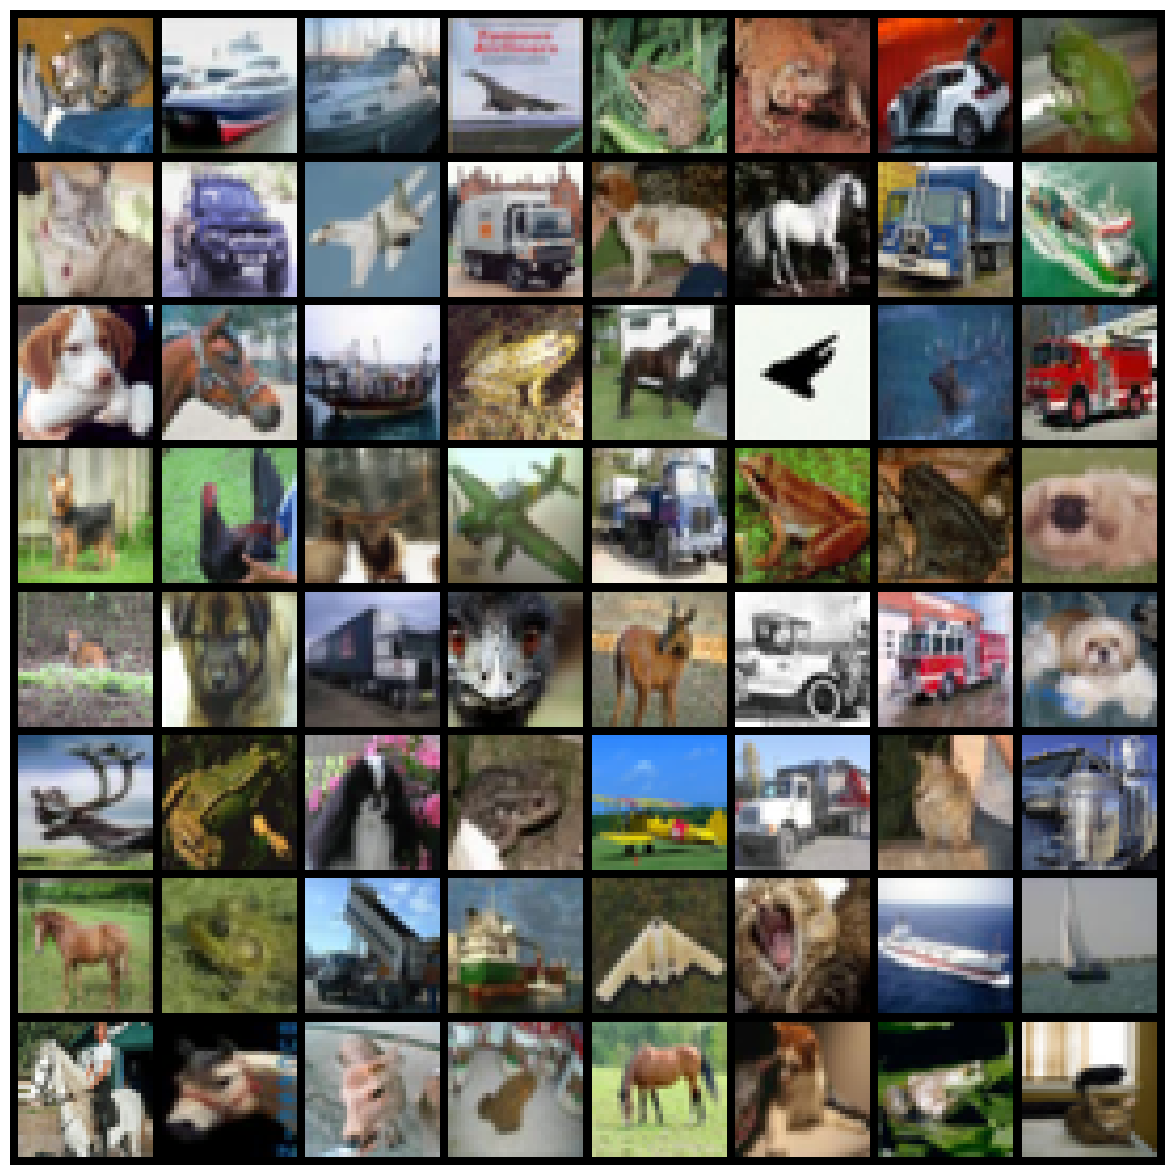

In [88]:
samples, _ = next(iter(loader_test))

samples = samples.cpu()
samples = make_grid(denorm(samples), nrow=8, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize = (15,15))
plt.axis('off')
show(samples)

#### Model Definition
Define hyperparameters and the model

In [90]:
# *CODE FOR PART 2.1 IN THIS CELL*

# Choose the number of epochs, the learning rate
# and the size of the Generator's input noise vetor.

num_epochs = 200
learning_rate = 3e-04
latent_vector_size = 70


In [91]:
# *CODE FOR PART 2.1 IN THIS CELL*

image_dim = 32
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0,
        # groups=1, bias=True, dilation=1, padding_mode='zeros', device=None, dtype=None)
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(latent_vector_size, image_dim * 16, 4, 1, 0, bias=False), ## Out Size: (512, 4, 4)
            nn.BatchNorm2d(image_dim * 16),
            nn.ReLU(True),
            nn.ConvTranspose2d(image_dim * 16, image_dim * 8, 4, 2, 1, bias=False), ## Out Size: (256, 8, 8)
            nn.BatchNorm2d(image_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(image_dim * 8, image_dim * 4, 4, 2, 1, bias=False), ## Out Size: (128, 16, 16)
            nn.BatchNorm2d(image_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(image_dim * 4, 3, 4, 2, 1, bias=False), ## Out Size: (3, 32, 32)
            nn.Tanh()
        )




        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, z):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.generate(z)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################
        return out


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        # Use leaky Relu to prevent "dying ReLU" problem,
        self.discriminate = nn.Sequential(
            ## Do not use batch norm here, batch norm usually used in later layers
            nn.Conv2d(3, image_dim * 4, 4, 2, 1, bias=False), # Out (128,16,16)
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout2d(0.05), ## Dropout added to increase generalisation
            nn.Conv2d(image_dim * 4, image_dim * 8, 4, 2, 1, bias=False), # Out (128,16,16)
            nn.BatchNorm2d(image_dim * 8),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout2d(0.1), ## Dropout increases gradually
            nn.Conv2d(image_dim * 8, image_dim * 16, 4, 2, 1, bias=False), # Out (512,4,4)
            nn.BatchNorm2d(image_dim * 16),
            nn.LeakyReLU(0.2, inplace = True),
            nn.Dropout2d(0.2), ## Dropout increases gradually
            nn.Conv2d(image_dim * 16, 1, 4, 1, 0, bias=False), # Out (1) since it is image
            nn.Sigmoid() # Use sigmoid since this is image

        )
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

    # You can modify the arguments of this function if needed
    def forward(self, x):
        #######################################################################
        #                       ** START OF YOUR CODE **
        #######################################################################
        out = self.discriminate(x)
        #######################################################################
        #                       ** END OF YOUR CODE **
        #######################################################################

        return out


<h2> Initialize Model and print number of parameters </h2>

You can use method `weights_init` to initialize the weights of the Generator and Discriminator networks. Otherwise, implement your own initialization, or do not use at all. You will not be penalized for not using initialization.

In [92]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [93]:
use_weights_init = True

model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 3202816
Generator(
  (generate): Sequential(
    (0): ConvTranspose2d(70, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


Total number of parameters in Discriminator is: 2637312
Discriminator(
  (discriminate): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2),

### Part 2.1b: Training the Model (12 Points)

#### Defining a Loss

In [94]:
# You can modify the arguments of this function if needed
loss_criteria = nn.BCELoss(reduction='mean')
def loss_function(out, label):
    loss = loss_criteria(out, label)
    return loss

<h3>Choose and initialize optimizers</h3>

In [95]:
# setup optimizer
# You are free to add a scheduler or change the optimizer if you want. We chose one for you for simplicity.
beta1 = 0.5
optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate, betas=(beta1, 0.999))
schedD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size = 10, gamma = 0.8)
schedG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size = 10, gamma = 0.8)


<h3> Define fixed input vectors to monitor training and mode collapse. </h3>

In [96]:
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
# Additional input variables should be defined here
real_label = 1
fake_label = 0

#### Training Loop

Complete the training loop below. We've defined some variables to keep track of things during training:
* errD: Loss of Discriminator after being trained on real and fake instances
* errG: Loss of Generator
* D_x: Output of Discriminator for real images
* D_G_z1: Output of Discriminator for fake images (When Generator is not being trained)
* D_G_z2: Output of Discriminator for fake images (When Generator is being trained)

In [97]:
train_losses_G = []
train_losses_D = []

# <- You may wish to add logging info here
for epoch in range(num_epochs):
    # <- You may wish to add logging info here
    with tqdm.tqdm(loader_train, unit="batch") as tepoch:
        train_loss_D = 0
        train_loss_G = 0
        for i, data in enumerate(tepoch):
            #######################################################################
            #                       ** START OF YOUR CODE **
            #######################################################################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

            #### train with real ####
            model_D.zero_grad()

            # Prepare Data
            real_cpu = data[0].to(device)
            batch_size = real_cpu.size(0)

            # Get output of discriminator
            label = torch.full((batch_size,), real_label, device=device).type(torch.FloatTensor).to(device)
            Discriminator_out = model_D(real_cpu).view(-1, 1).squeeze(1)

            #Discriminator_out = Discriminator_out.to(torch.float32)
            #label = label.to(torch.float32)

            # Get Discriminator Error.
            real_Discriminator_err = loss_function(Discriminator_out, label)
            real_Discriminator_err.backward()

            # Extract D(x)
            D_x = Discriminator_out.mean().item()

            #########################
            #### train with fake ####
            noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)
            Generator_out = model_G(noise)

            # Get Fake Generated Data from Generator Output.
            label = torch.full((batch_size,), fake_label, device=device).type(torch.FloatTensor).to(device)

            # Use the discriminator to fight the generatoed data
            fake_out = model_D(Generator_out.detach()).view(-1, 1).squeeze(1)

            # Discriminator error for the fake data.
            fake_Discriminator_err = loss_function(fake_out, label)
            fake_Discriminator_err.backward()

            # D(G(z1)) Output of discriminnator for fake image
            D_G_z1 = fake_out.mean().item()
            errD = real_Discriminator_err + fake_Discriminator_err
            train_loss_D += errD.item()
            optimizerD.step()

            #########################################################
            ###### (2) Update G network: maximize log(D(G(z))) ######
            model_G.zero_grad()

            # Set up real label
            label = torch.full((batch_size,), real_label, device=device).type(torch.FloatTensor).to(device)

            # Discriminator on real
            DG_out = model_D(Generator_out).view(-1, 1).squeeze(1)

            # Get Error.
            errG = loss_function(DG_out, label)
            errG.backward()

            # D(G(z1)) Output)
            D_G_z2 = DG_out.mean().item()
            train_loss_G += errG.item()

            # Run Optimizer step.
            optimizerG.step()

            #######################################################################
            #                       ** END OF YOUR CODE **
            #######################################################################
            # Logging
            if i % 50 == 0:
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(D_G_z=f"{D_G_z1:.3f}/{D_G_z2:.3f}", D_x=D_x,
                                  Loss_D=errD.item(), Loss_G=errG.item())


    if schedD is not None and schedG is not None:
        schedD.step()
        schedG.step()

    if epoch == 0:
        save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
    with torch.no_grad():
        fake = model_G(fixed_noise)
        save_image(denorm(fake.cpu()).float(), str(content_path/'CW_GAN/fake_samples_epoch_%03d.png') % epoch)
    train_losses_D.append(train_loss_D / len(loader_train))
    train_losses_G.append(train_loss_G / len(loader_train))

# save  models
# if your discriminator/generator are conditional you'll want to change the inputs here
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

Epoch 199: 100%|██████████| 782/782 [01:16<00:00, 10.21batch/s, D_G_z=0.155/0.129, D_x=0.872, Loss_D=0.46, Loss_G=3.17]
/usr/local/lib/python3.10/dist-packages/torch/jit/_trace.py:1093: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 64 / 64 (100.0%)
Greatest absolute difference: 0.8488644864410162 at index (41, 0, 0, 0) (up to 1e-05 allowed)
Greatest relative difference: 1571.0538612000923 at index (21, 0, 0, 0) (up to 1e-05 allowed)
  _check_trace(


## Part 2.1c: Results (10 Points)
This part is fairly open-ended, but not worth too much so do not go crazy. The table below shows examples of what are considered good samples. Level 3 and above will get you 10/10 points, level 2 will roughly get you 5/10 points and level 1 and below will get you 0/10 points.

<table><tr>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=18aWqRAnAVTRDY52y1yHSCdqSxUFRKOS9" width="%30">
    <br>
    <em style="color: grey">Level 1</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=1ymO2-jGAvWeUR2kaj_LxQcGYF1RWNRnw" width="%30">
    <br>
    <em style="color: grey">Level 2</em>
  </p>
</td>
<td>
  <p align="center">
    <img alt="Routing" src="https://drive.google.com/uc?id=13SW62ekW32NMYtfcdm_dCJJ3ZMOZEZAJ" width="%30">
    <br>
    <em style="color: grey">Level 3</em>
  </p>
</td>
</tr></table>

### Generator samples

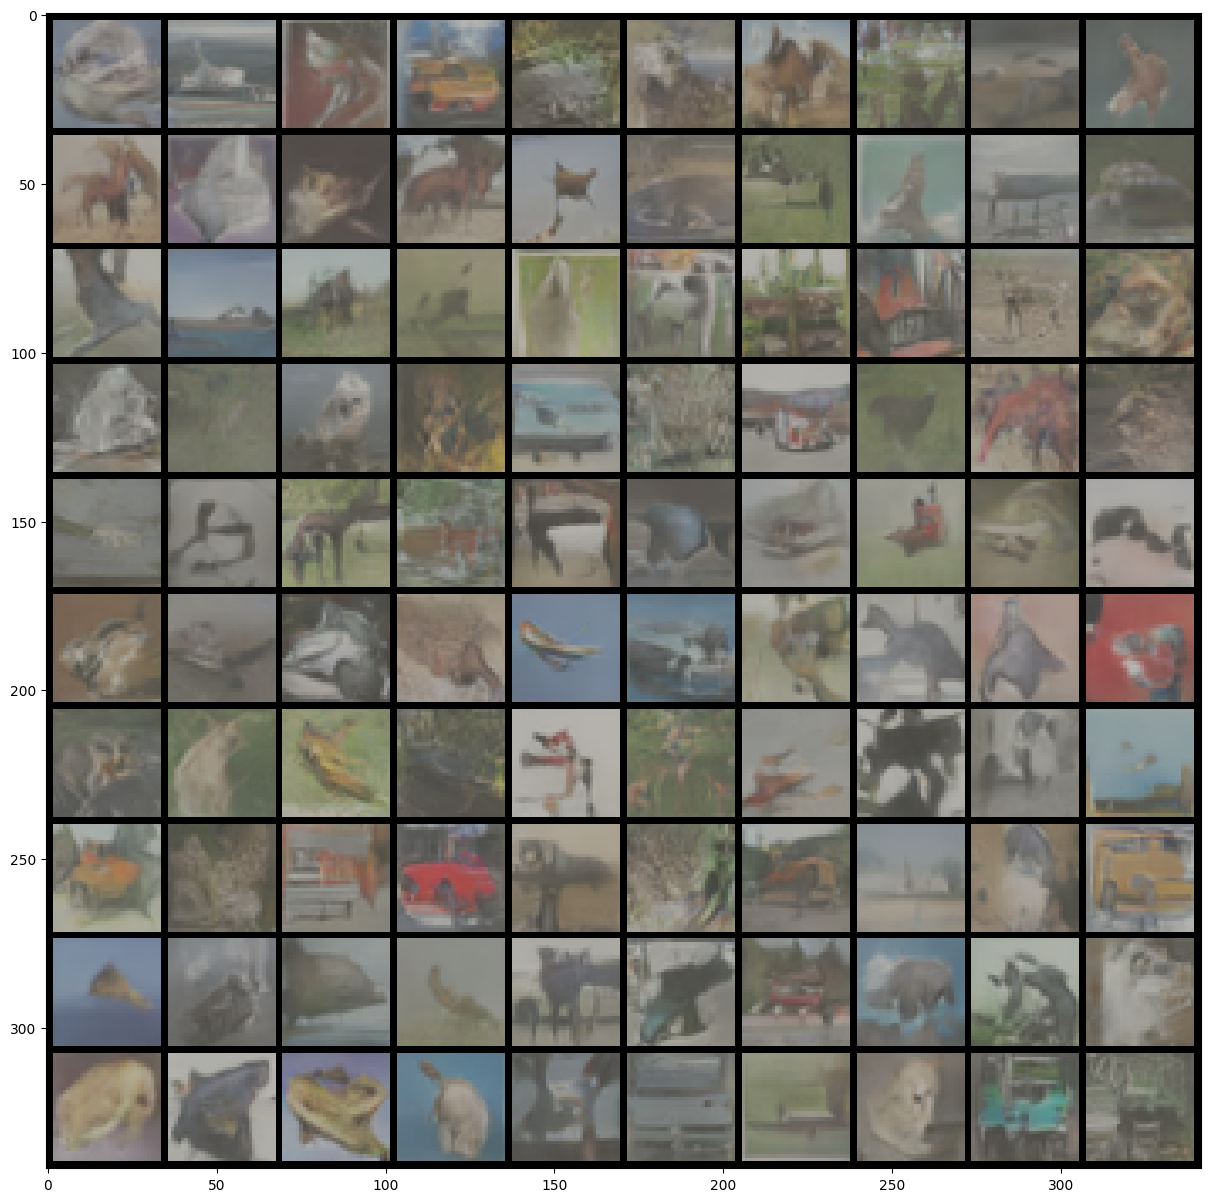

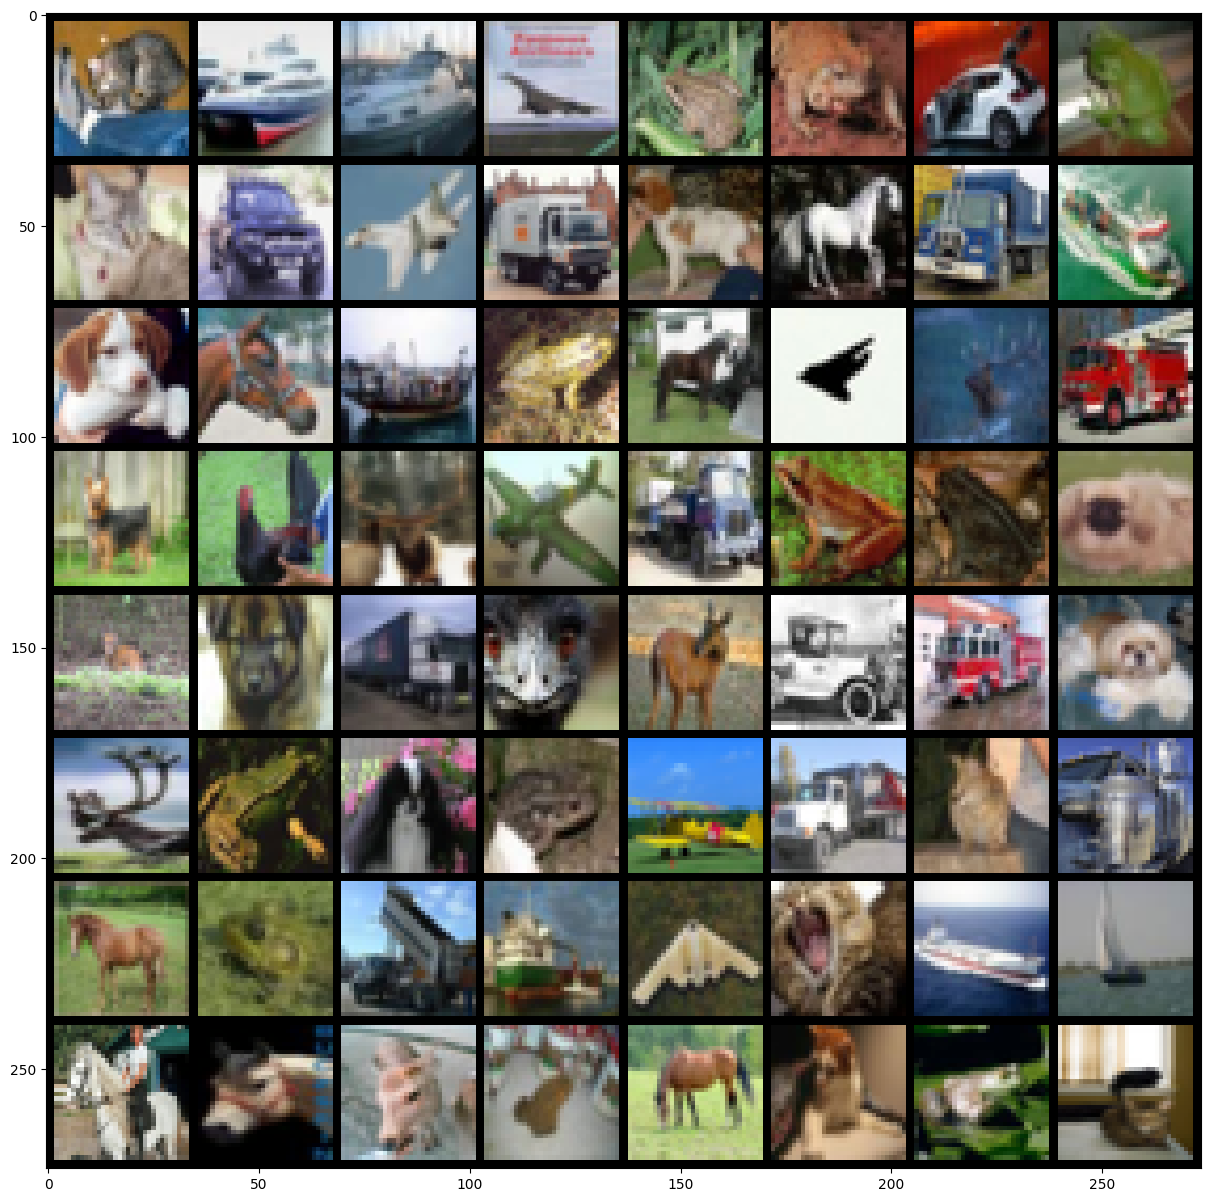

In [98]:
input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False,
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)

## Part 2.1d: Engineering Choices (10 Points)

Discuss the process you took to arrive at your final architecture. This should include:

* Which empirically useful methods did you utilize
* What didn't work, what worked and what mattered most
* Are there any tricks you came across in the literature etc. which you suspect would be helpful here

**Your Answer**


**Which empirically useful methods did you utilize**

I utilised a really common but simple architecture for creating a GAN.

**Generator**: Used 4 Convolution transpose layer, which 3 utilised ReLU and last one used TanH. TanH was used because it produces output values of [-1,1]. CIFAR-10 has been pre-processed to have pixel values between -1 to 1 also. Here we are upsampling the image after every convolution layer to eventually reach the desired output image dimension of 32x32 pixel which is typical for CIFAR-10 dataset

**Discriminator**: Here we similarly used 4 convolution transpose layer. Based on online search results, it seems that using LeakyRelu and adding dropout, the discriminator is supposed to be able to better identify the difference between real and fake images, hence making the discriminator more powerful. 
Found that increasing dropout gradually after each layer can help to control overfitting and improve regularisation better.

One key part of discriminator is that the use of a sigmoid function at the final layer to output 0 or 1. Because it is a classification for real vs fake image.

**Tricks**
1. Adding dropout to discriminator is useful to accelerate convergence initially. but it was recommended to increase dropout gradually. (But did not have much time to test these hyperparameters)
2. Used Relu to avoid vanishing gradient issue in generator.
3. Epoch of 50 to 100 seems sufficient. Beyond this not much impact.
4. Fully connected layers may not be useful hence never tried this in the code.
5. Use LR schedulers to accelerate the rate of training.

**Most important optimisations**

Due to the limited time i have to modify hyper parameters. 3 factors seems to affect the training of model.
1. Learning rate => Small changes to learning rate seem to affect the performance greatly.
2. Schedulers => having a scheduler to decrease learning rate overtime increases the convergence
3. Batch size: larger batch size of above 200 seem to result in a drop in performance. 32 to 64 seems best for me

Generally i don't have much time to train multiple models or modify the architecture much. Used what was recommended based on existing literatures online.







## Part 2.2: Understanding GAN Training (5 points)


### Loss Curves
**Your task:**


Plot the losses curves for the discriminator $D$ and the generator $G$ as the training progresses and explain whether the produced curves are theoretically sensible and why this is (or not) the case (x-axis: epochs, y-axis: loss).

Make sure that the version of the notebook you deliver includes these results.

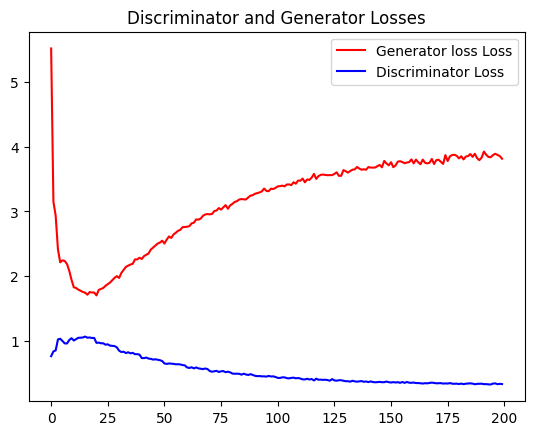

In [99]:
# ANSWER FOR PART 2.2 IN THIS CELL*
plt.plot(list(range(0, np.array(train_losses_G).shape[0])), np.array(train_losses_G), label='Generator loss Loss', c='r')
plt.plot(list(range(0, np.array(train_losses_D).shape[0])), np.array(train_losses_D), label='Discriminator Loss', c='b')
plt.legend()
plt.title('Discriminator and Generator Losses')
plt.show()

### Discussion

Do your loss curves look sensible? What would you expect to see and why?

**YOUR ANSWER**

Curves are sensible and expected. We observe initially that the generator loss is super high because it generates noisy image.The loss quickly decreases. toward the 150 to 200 epoch the loss seem to converge to about 3.5.
The discriminator the discriminator increases slightly before decreasing and converging to a value of 0.4-0.6. It suggests that the generator is producing images of sufficient quality that they are, on average, as likely to be classified as real as actual real image


Generally both losses appear as expected as they converge. 

## Part 2.3: Understanding Mode Collapse (5 points)
**Your task:**

Describe the what causes the phenomenon of Mode Collapse and how it may manifest in the samples from a GAN.

Based on the images created by your generator using the `fixed_noise` vector during training, did you notice any mode collapse? what this behaviour may be attributed to, and what did you try to eliminate / reduce it?

### Discussion


**YOUR ANSWER**

Mode collapse occurs when generator produces a very small number of outputs that are good at deceiving the discriminator. The generator becomes fixated on a few models that fail to produce a varied number of images that is representative of the image set given.

There seem to be some mode collapse, like multiple repeated images of airplanes, frog, horses and ships. 

To optimise this and reduce it:
1. Latent space - used higher latent space
2. Batch normalisation and Dropout was used
3. Smaller batchsize: used between 32 to 64, rather than 128 and above.





# TA Test Cell
TAs will run this cell to ensure that your results are reproducible, and that your models have been defined suitably.

<font color="orange"> <b> Please provide the input and output transformations required to make your VAE and GANs work. If your GAN generator requires more than just noise as input, also specify this below (there are two marked cells for you to inspect) </b></font>


In [100]:
# If you want to run these tests yourself, change directory:
# %cd '.../dl_cw2/'
# ta_data_path = "../data" # You can change this to = data_path when testing
ta_data_path = content_path # You can change this to = data_path when testing


In [101]:
!pip install -q torch torchvision

In [102]:
# Do not remove anything here
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
import torch.nn.functional as F
import matplotlib.pyplot as plt

show = lambda img: plt.imshow(np.transpose(img.cpu().numpy(), (1,2,0)))

device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")

# Do not change this cell!
torch.backends.cudnn.deterministic = True
torch.manual_seed(0)

In [103]:
############# CHANGE THESE (COPY AND PASTE FROM YOUR OWN CODE) #############
vae_transform = transforms.Compose([
    transforms.ToTensor(),
])

def vae_denorm(x):
    return x

def gan_denorm(x):
    return x

gan_latent_size = 70

# If your generator requires something other than noise as input, please specify
# two cells down from here

In [104]:
# Load VAE Dataset
test_dat = datasets.MNIST(ta_data_path, train=False, transform=vae_transform,
                          download=True)
vae_loader_test = DataLoader(test_dat, batch_size=32, shuffle=False)

In [105]:
############# MODIFY IF NEEDED #############
vae_input, _ = next(iter(vae_loader_test))

# If your generator is conditional, then please modify this input suitably
input_noise = torch.randn(100, gan_latent_size, 1, 1, device=device)
gan_input = [input_noise] # In case you want to provide a tuple, we wrap ours

Used CNN


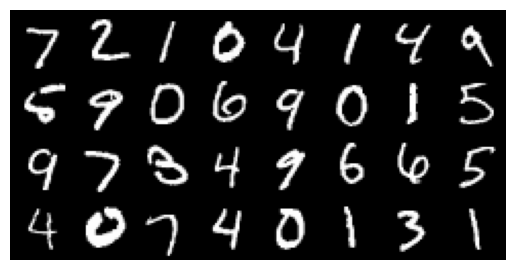

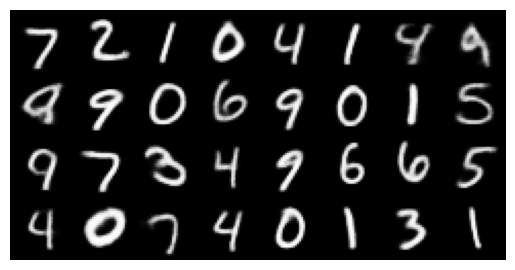

In [106]:
# VAE Tests
# TAs will change these paths as you will have provided the model files manually
"""To TAs, you should have been creating a folder with the student uid
   And the .ipynb + models in the root. Then that path is './VAE_model.pth' etc.
"""
# vae = model_G = torch.jit.load('./CW_VAE/VAE_model.pth') ## Uncomment later
vae = model_G = torch.jit.load(content_path/'CW_VAE/VAE_model.pth') ## For testing
vae.eval()

# Check if VAE is convolutional
def recurse_cnn_check(parent, flag):
    if flag:
        return flag
    children = list(parent.children())
    if len(children) > 0:
        for child in children:
            flag = flag or recurse_cnn_check(child, flag)
    else:
        params = parent._parameters
        if 'weight' in params.keys():
            flag = params['weight'].ndim == 4
    return flag

has_cnn = recurse_cnn_check(vae, False)
print("Used CNN" if has_cnn else "Didn't Use CNN")

vae_in = make_grid(vae_denorm(vae_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_in)

vae_test = vae(vae_input.to(device))[0].detach()
vae_reco = make_grid(vae_denorm(vae_test), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure()
plt.axis('off')
show(vae_reco)

Number of Parameters is 5840128 which is ok


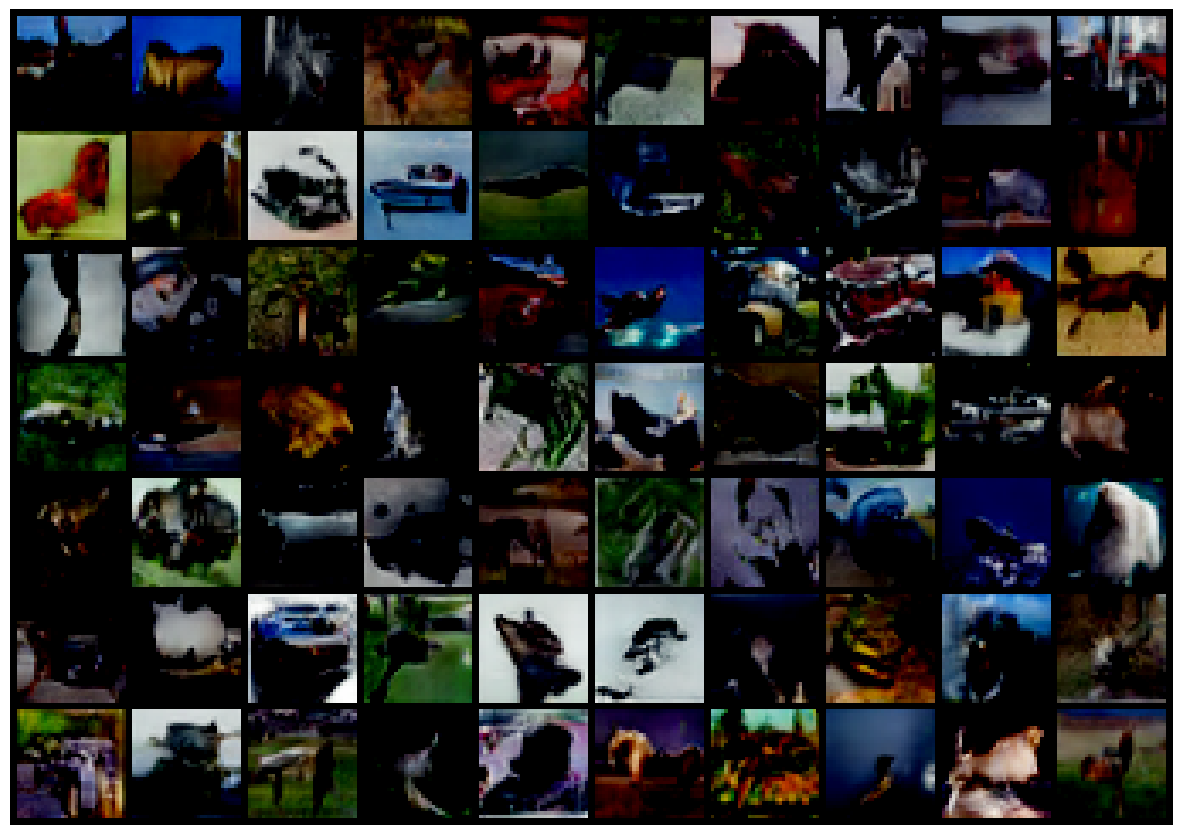

In [108]:
# GAN Tests
# model_G = torch.jit.load('./CW_GAN/GAN_G_model.pth')
# model_D = torch.jit.load('./CW_GAN/GAN_D_model.pth')
model_G = torch.jit.load(content_path/'CW_GAN/GAN_G_model.pth')
model_D = torch.jit.load(content_path/'CW_GAN/GAN_D_model.pth')
[model.eval() for model in (model_G, model_D)]

# Check that GAN doesn't have too many parameters
num_param = sum(p.numel() for p in [*model_G.parameters(),*model_D.parameters()])

print(f"Number of Parameters is {num_param} which is", "ok" if num_param<25E+6 else "not ok")

# visualize the generated images
generated = model_G(*gan_input).cpu()
generated = make_grid(gan_denorm(generated)[:70].detach(), nrow=10, padding=2, normalize=False,
                    value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
plt.axis('off')
show(generated)